In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from dask.distributed import LocalCluster
from scipy import interpolate, signal
%matplotlib inline

In [3]:
client = LocalCluster()
client

In [4]:
fdir = "D:/crs/proj/2019_DorianOBX/WayneWright_flights/"

fnames = (\
          "post_Matthew_lidar_1m.tif",\
          "2019-08-30_1m_DEM_v1.tif",\
          "2019-09-12-13_DEM_1m_v1.tif")

titles = ([\
         "post-Matthew",\
         "pre-Dorian",\
         "post-Dorian"])

nf = len(fnames)

# optional median-filter smoothing of original maps
smooth = False
# kernal size...this should be an odd number >= dxy/0.1
ksize = 3

In [5]:
def box2UTMh(x, y, x0, y0, theta):
    '''
    2D rotation and translation of x, y
    Input:
        x, y - row vectors of original coordinates (must be same size)
        x0, y0 - Offset (location of x, y = (0,0) in new coordinate system)
        theta - Angle of rotation (degrees, CCW from x-axis == Cartesian coorinates)
    Returns:
        xr, yr - rotated, offset coordinates
    '''
    thetar = np.radians(theta)
    c, s = np.cos(thetar), np.sin(thetar)

    # homogenous rotation matrix
    Rh = np.array(((c, -s,  0.),\
                   (s,  c,  0.),\
                   (0., 0., 1.)))
    # homogenous translation matrix
    Th = np.array(((1., 0., x0),\
                   (0., 1., y0),\
                   (0., 0., 1.)))
    
    # homogenous input x,y
    xyh = np.vstack((x,y,np.ones_like(x)))

    # perform rotation and translation
    xyrh=np.matmul(np.matmul(Th,Rh),xyh)
    xr = xyrh[0,:]
    yr = xyrh[1,:]
    return xr, yr

In [6]:
def map_stats(mp):
    '''
    Calculate some basic statistics for 3D map arrays
    '''
    mean = np.nanmean(mp,axis=(1,2))
    mad = np.nanmean(np.abs(mp),axis=(1,2))
    dmin = np.nanmin(mp,axis=(1,2))
    dmax = np.nanmax(mp,axis=(1,2))
    rms = np.sqrt(np.nanmean(mp**2.,axis=(1,2)))
    print("mean",mean)
    print("mad",mad)
    print("min",dmin)
    print("max",dmax)
    print("rms",rms)
    return mean, mad

In [7]:
# make a small box w/ cell centered grid with spacing dxy
dxy = 1.
xmax = 1800. # alongshore
ymax = 500.  # cross-shore
nx = int((1./dxy)*xmax)
ny = int((1./dxy)*ymax)

xcoords = np.linspace(0.5*dxy,xmax-0.5*dxy,nx)
ycoords = np.linspace(0.5*dxy,ymax-0.5*dxy,ny)
# Y is ascending
xrot, yrot=np.meshgrid(xcoords, ycoords ,sparse=False, indexing='xy')
print("xrot:")
print(xrot.shape)
print(xrot)
print("yrot:")
print(yrot.shape)
print(yrot)

xrot:
(500, 1800)
[[5.0000e-01 1.5000e+00 2.5000e+00 ... 1.7975e+03 1.7985e+03 1.7995e+03]
 [5.0000e-01 1.5000e+00 2.5000e+00 ... 1.7975e+03 1.7985e+03 1.7995e+03]
 [5.0000e-01 1.5000e+00 2.5000e+00 ... 1.7975e+03 1.7985e+03 1.7995e+03]
 ...
 [5.0000e-01 1.5000e+00 2.5000e+00 ... 1.7975e+03 1.7985e+03 1.7995e+03]
 [5.0000e-01 1.5000e+00 2.5000e+00 ... 1.7975e+03 1.7985e+03 1.7995e+03]
 [5.0000e-01 1.5000e+00 2.5000e+00 ... 1.7975e+03 1.7985e+03 1.7995e+03]]
yrot:
(500, 1800)
[[  0.5   0.5   0.5 ...   0.5   0.5   0.5]
 [  1.5   1.5   1.5 ...   1.5   1.5   1.5]
 [  2.5   2.5   2.5 ...   2.5   2.5   2.5]
 ...
 [497.5 497.5 497.5 ... 497.5 497.5 497.5]
 [498.5 498.5 498.5 ... 498.5 498.5 498.5]
 [499.5 499.5 499.5 ... 499.5 499.5 499.5]]


In [8]:
# Define the ROI with bottom left corner and rotation of axes
#e0 = 391210.; n0 = 3868600.
e0 = 391460.; n0 = 3868410.

rot = 43.

print('Shape of xrot, yrot: ',np.shape(xrot),np.shape(xrot))
shp = np.shape(xrot)
xu, yu = box2UTMh(xrot.flatten(), yrot.flatten(), e0, n0, rot)
xu=np.reshape(xu,shp)
yu=np.reshape(yu,shp)
print('Shape of xu and yu: ',np.shape(xu),np.shape(yu))

Shape of xrot, yrot:  (500, 1800) (500, 1800)
Shape of xu and yu:  (500, 1800) (500, 1800)


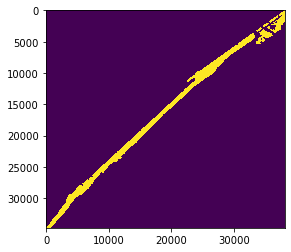

In [9]:
# check rotations using lidar DEM
fn = fdir+fnames[0]
da = xr.open_rasterio(fn)
plt.imshow(np.squeeze(da))


In [10]:
%%time

dslist=[]
for i in range(nf):
    fn = fdir+fnames[i]
    print(i, fn)
    
    # open the tif with XArray as a DataArray
    da = xr.open_rasterio(fn)
    
    print( np.shape(np.flipud(da['y'].values)), np.shape(da['x'].values), np.shape( np.flipud(da.values)) )
    x = da['x'].values
    y = np.flipud(da['y'].values)
    
    # Not sure how da.values got a singleton dimension, but squeeze gets rid of it.
    # However, make sure to squeeze before flipping
    z = np.flipud(np.squeeze(da.values))
    print(np.shape(x),np.shape(y),np.shape(z))
    

    if(smooth):
        # smooth with 2D running median
        zs = signal.medfilt2d(z, kernel_size=ksize)
    else:
        zs = z
    
    f = interpolate.RegularGridInterpolator( (y, x), zs, method='linear')   
    
    # Array for interpolated elevations
    zi=np.NaN*np.ones((ny,nx))

    # this is a slow iteration through all of the points, but allows us to skip ones that are outside
    for ij in np.ndindex(zi.shape):
        try:
            zi[ij]=f((yu[ij],xu[ij]))
        except:
            zi[ij]=np.NaN
            
    da = xr.DataArray(zi,dims=['Alongshore','Cross-shore'],coords={'Alongshore': ycoords, 'Cross-shore':xcoords })
    # dslist.append(da.chunk()) # this does not work...can't concatenate a method
    da = da.chunk()
    dslist.append(da)

dsa = xr.concat(dslist, dim='map')

0 D:/crs/proj/2019_DorianOBX/WayneWright_flights/post_Matthew_lidar_1m.tif
(34727,) (38113,) (1, 34727, 38113)
(38113,) (34727,) (34727, 38113)
1 D:/crs/proj/2019_DorianOBX/WayneWright_flights/2019-08-30_1m_DEM_v1.tif
(33890,) (36740,) (1, 33890, 36740)
(36740,) (33890,) (33890, 36740)
2 D:/crs/proj/2019_DorianOBX/WayneWright_flights/2019-09-12-13_DEM_1m_v1.tif
(33040,) (35850,) (1, 33040, 35850)
(35850,) (33040,) (33040, 35850)
Wall time: 6min 26s


In [11]:
print(np.shape(dsa.values))
dsa.load()

(3, 500, 1800)


<xarray.DataArray (map: 3, Alongshore: 500, Cross-shore: 1800)>
array([[[-4.227842e-02, -5.834684e-02, ..., -2.518436e-01, -2.483739e-01],
        [ 1.047269e-02,  9.393187e-04, ..., -2.341582e-01, -2.331109e-01],
        ...,
        [-8.080528e-01, -7.922446e-01, ...,  6.841041e-01,  7.342958e-01],
        [-7.690433e-01, -7.712837e-01, ...,  6.510642e-01,  7.467786e-01]],

       [[ 6.725825e-01,  6.584825e-01, ...,  1.472508e-01,  1.203142e-02],
        [ 7.259717e-01,  7.247591e-01, ...,  4.270064e-02,  6.847484e-02],
        ...,
        [-2.016745e+00, -4.120455e+00, ...,  8.975057e-01,  9.385143e-01],
        [-1.800312e+00, -1.708539e+00, ...,  8.920179e-01,  9.266685e-01]],

       [[-1.457244e-02, -9.286236e-02, ..., -1.024621e-01, -5.651700e-01],
        [-2.407596e-02, -2.586011e-02, ..., -5.417199e-01, -1.201668e+00],
        ...,
        [-3.525645e+00, -3.805180e+00, ...,  9.605909e-01,  1.007047e+00],
        [-4.438722e+00, -4.796751e+00, ...,  9.346941e-01,  9.554796

In [12]:
map_stats(dsa)

mean [1.65046052 1.92659075 1.60491351]
mad [1.71191964 1.96625731 1.6622469 ]
min [ -1.47623482  -5.30674441 -12.10145638]
max [ 6.60924107  8.40669734 12.01024608]
rms [1.96056426 2.2548942  2.00492131]


(array([1.65046052, 1.92659075, 1.60491351]),
 array([1.71191964, 1.96625731, 1.6622469 ]))

In [23]:
dsaa = dsa.copy()
dsaa[1,:,:] = dsaa[1,:,:] - 0.20

dsaa = dsaa.where(dsaa>=0.4)
map_stats(dsaa)

mean [1.87709967 1.95034116 1.86346391]
mad [1.87709967 1.95034116 1.86346391]
min [0.40000408 0.40000592 0.40000756]
max [ 6.60924107  8.20669734 12.01024608]
rms [2.07036986 2.19720795 2.13859951]


(array([1.87709967, 1.95034116, 1.86346391]),
 array([1.87709967, 1.95034116, 1.86346391]))

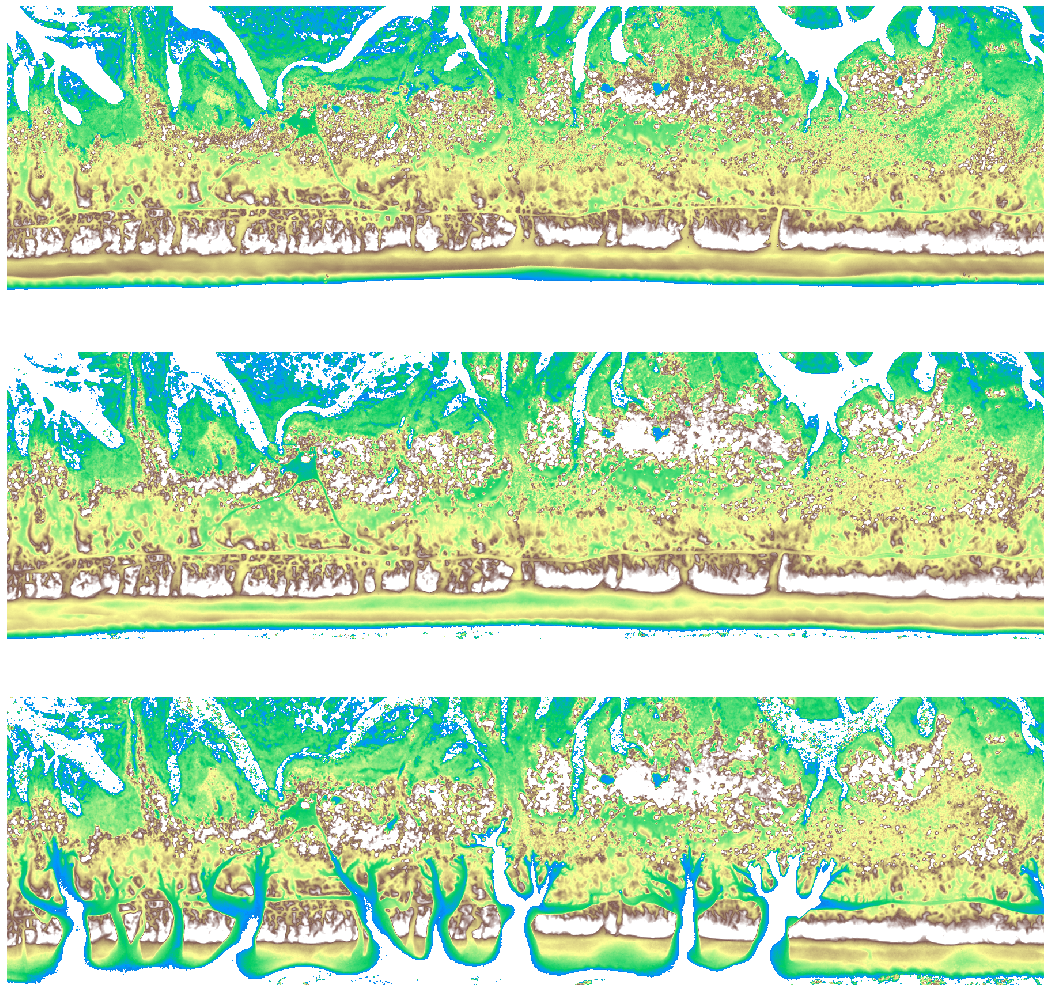

In [24]:
# declare a plot size
plt.subplots(figsize=(24,18))

for i in range(nf):
    # small plots of elevation
    plt.subplot(3,1,i+1); plt.axis('off'); plt.imshow(np.flipud(dsaa[i,:,:]),cmap=plt.cm.terrain,vmin=0,vmax=3.5)

(2, 500, 1800)


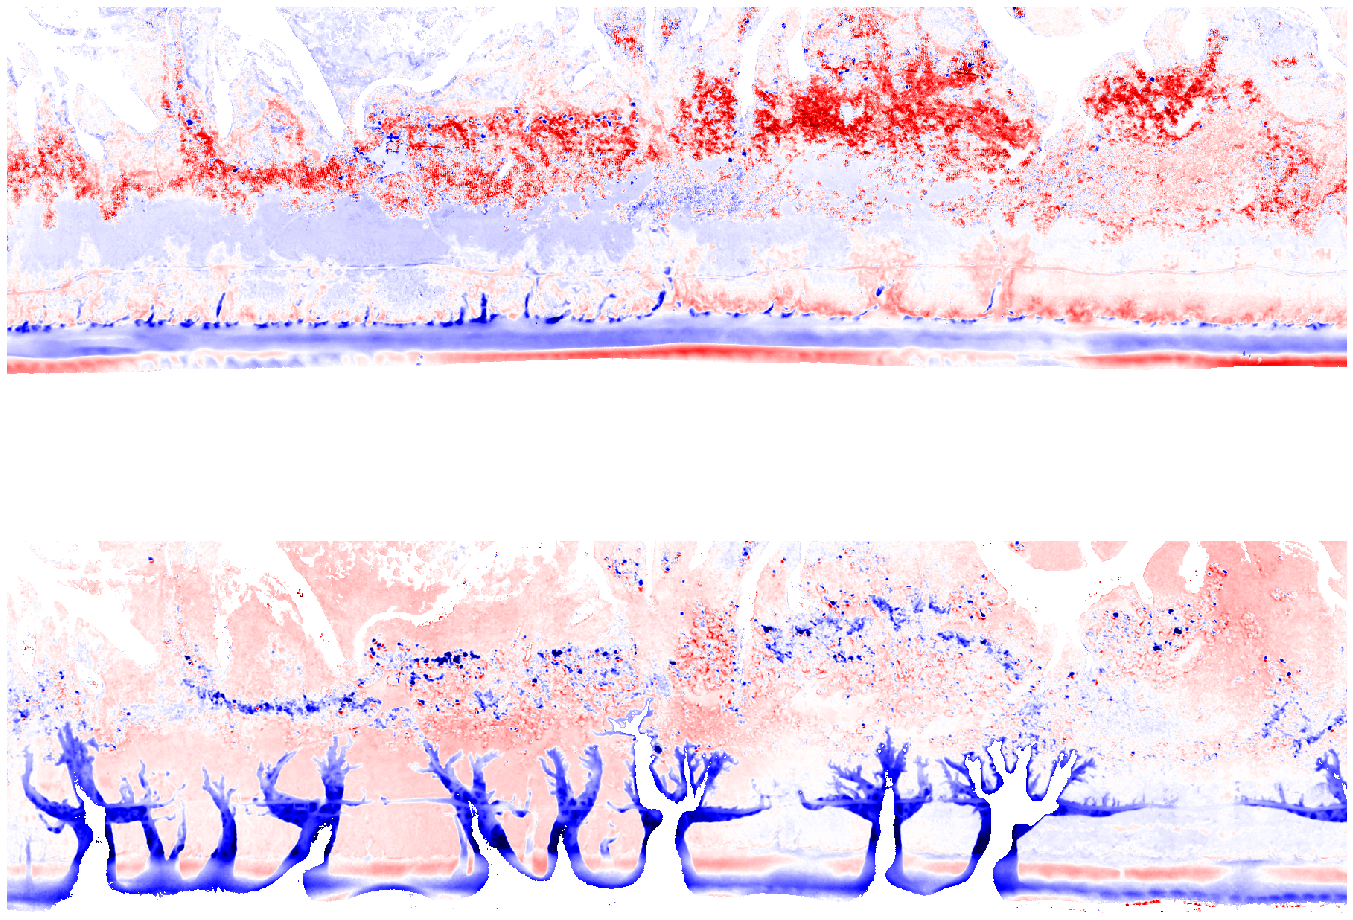

In [25]:
# plot diff maps
diffmap = np.diff(dsaa,n=1,axis=0)
plt.subplots(figsize=(24,18))
print(np.shape(diffmap))
for i in range(2):
    # small plots of elevation
    plt.subplot(2,1,i+1); plt.axis('off'); plt.imshow(np.flipud(diffmap[i,:,:]),cmap=plt.cm.seismic,vmin=-3,vmax=3.)